In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

/home/tomas/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pin = Path(r'/home/tomas/Github/ECE542_prjC_NCSU/model01/models')
files = sorted([x for x in os.listdir(pin) if x.endswith('.csv')])
dct = {f'sub{i+1}out':pd.read_csv(pin/files[i], index_col = 0) for i in range(8)}

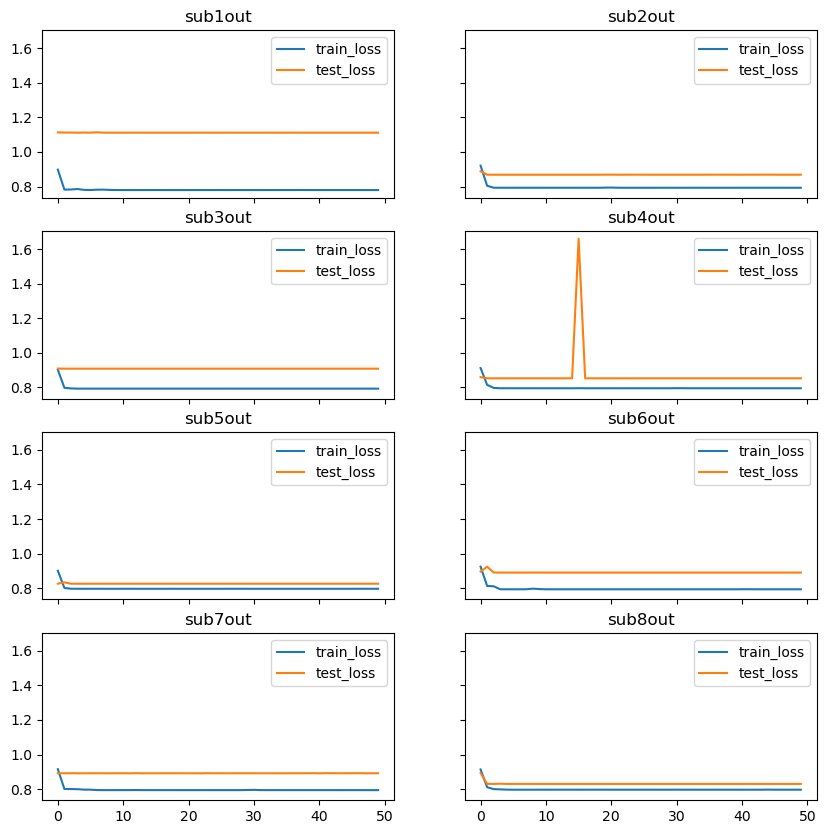

In [3]:
fig, ax = plt.subplots(figsize = (10, 10), ncols = 2, nrows = 4, sharex = True, sharey=True)
for ik, k in enumerate(dct.keys()):
    axs = ax.flatten()[ik]
    dct[k].plot(ax = axs)
    axs.set_title(k)

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.lstm1 = nn.LSTM(input_size=6, hidden_size=64, num_layers=4, batch_first=True, bidirectional = True)
    self.bn1 = nn.BatchNorm1d(num_features = 128)
    self.fc1 = nn.Linear(in_features = 128, out_features = 128)
    self.bn2 = nn.BatchNorm1d(num_features=128)
    self.fc2 = nn.Linear(in_features = 128, out_features = 64)
    self.bn3 = nn.BatchNorm1d(num_features=64)
    self.fc3 = nn.Linear(in_features = 64, out_features = 32)
    self.bn4 = nn.BatchNorm1d(num_features=32)
    self.fc4 = nn.Linear(in_features = 32, out_features = 16)
    self.bn5 = nn.BatchNorm1d(num_features=16)
    self.fc5 = nn.Linear(in_features = 16, out_features = 4)
    self.dout = nn.Dropout(p=0.2)

  def forward(self, x):
    # print(f'Input shape: {x.shape}')
    x, _ = self.lstm1(x)
    x = x[:, -1, :]
    # print(x.shape)
    # x = self.bn1(x)
    # x = self.dout(x)
    
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)
    
    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.fc4(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.fc5(x)
    x = F.softmax(x, dim = 1)

    return x

In [5]:
models = sorted([x for x in os.listdir(pin) if x.endswith('.pt')])

In [6]:
models

['subject_1_out.pt',
 'subject_2_out.pt',
 'subject_3_out.pt',
 'subject_4_out.pt',
 'subject_5_out.pt',
 'subject_6_out.pt',
 'subject_7_out.pt',
 'subject_8_out.pt']

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.load_state_dict(torch.load(pin/models[0], map_location=device))
model.eval()

Net(
  (lstm1): LSTM(6, 64, num_layers=4, batch_first=True, bidirectional=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (bn5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=16, out_features=4, bias=True)
  (dout): Dropout(p=0.2, inplace=False)
)

In [9]:
pathData = Path(r'/home/tomas/Github/ECE542_prjC_NCSU/TrainingData')

# Define the header names for the 'x' CSV files
x_header = ["accx", "accy", "accz", "gyrox", "gyroy", "gyroz"]
# Define the header names for the 'x_time' CSV files
x_time_header = ["seconds"]

# Define the header names for the 'y' CSV files
y_header = ["class"]

# Define the header names for the 'y_time' CSV files
y_time_header = ["seconds"]

# Create an empty list to store the dataframes
dct = {}

filesAll = [x for x in os.listdir(pathData) if x.endswith('.csv')]

nSubjects = 8

for i in range(nSubjects):
    files = sorted([x for x in filesAll if x.startswith(f'subject_{i+1:03d}')])
    nSessions = int(len(files)/4) ## 4 files per session
    
    xdataAll = []
    ydataAll = []

    for j in range(nSessions):
        xdata = pd.read_csv(pathData/f'subject_{i+1:03d}_{j+1:02d}__x.csv', header = None, names = x_header)
        xdata['session'] = [j+1]*len(xdata)
        xtime = pd.read_csv(pathData/f'subject_{i+1:03d}_{j+1:02d}__x_time.csv', header = None, names = x_time_header)
        xdata['time'] = xtime['seconds'].values
        xdataAll.append(xdata)

        ydata = pd.read_csv(pathData/f'subject_{i+1:03d}_{j+1:02d}__y.csv', header = None, names = y_header)
        ydata['session'] = [j+1]*len(ydata)
        ytime = pd.read_csv(pathData/f'subject_{i+1:03d}_{j+1:02d}__y_time.csv', header = None, names = y_time_header)
        ydata['time'] = ytime['seconds'].values
        ydataAll.append(ydata)

    dfx = pd.concat(xdataAll)
    dfx.index = range(len(dfx))
    dfy = pd.concat(ydataAll)
    dfy.index = range(len(dfy))

    dct[f'subject_{i+1}_x'] = dfx
    dct[f'subject_{i+1}_y'] = dfy

In [10]:
input_tensor = torch.Tensor(dct['subject_1_x'].iloc[:, :-2].values)
input_tensor.to(device)
output_tensor = model(input_tensor)

: 

: 